# 9. Incorporating OD Veto Data

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import h5py
from scipy import signal
import matplotlib
from repeating_classifier_training_utils import *
from functools import reduce

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
veto_path = '/fast_scratch/WatChMaL/data/IWCDmPMT_4pm_full_tank_ODveto.h5'

In [3]:
odv_file = h5py.File(veto_path,'r')
odv_info = {}
for key in odv_file.keys():
    odv_info[key] = np.array(odv_file[key])

In [15]:
odv_dict = {}
pbar = ProgressBar(widgets=['Creating Event-Index Dictionary: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(odv_info['event_ids']))
pbar.start()
for i in range(len(odv_info['event_ids'])):
    odv_dict[(odv_info['root_files'][i], odv_info['event_ids'][i])] = i
    pbar.update(i)
pbar.finish()

Creating Event-Index Dictionary: 100% [0000000000000000000000000] Time: 0:00:15


## Load test set

In [12]:
# Get original h5 file info
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])

filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]

In [18]:
odv_mapping_indices = np.zeros(len(filtered_rootfiles))
pbar = ProgressBar(widgets=['Mapping Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(filtered_rootfiles))
pbar.start()
for i in range(len(filtered_rootfiles)):
    odv_mapping_indices[i] = odv_dict[(filtered_rootfiles[i], filtered_eventids[i])]
    pbar.update(i)
pbar.finish()
odv_mapping_indices = np.int32(odv_mapping_indices)

Mapping Progress: 100% [0000000000000000000000000000000000000000] Time: 0:00:09


In [23]:
pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(filtered_rootfiles))
pbar.start()
for i in range(len(filtered_rootfiles)):
    assert odv_info['root_files'][odv_mapping_indices[i]] == filtered_rootfiles[i]
    assert odv_info['event_ids'][odv_mapping_indices[i]] == filtered_eventids[i]
    pbar.update(i)
pbar.finish()

Verification Progress: 100% [00000000000000000000000000000000000] Time: 0:00:13


In [27]:
np.savez(os.path.join(os.getcwd(), 'Index_Storage/od_veto_mapping_idxs.npz'), mapping_idxs_full_set=odv_mapping_indices)

## Load test results

In [11]:
odv_mapping_idxs = np.load(os.path.join(os.getcwd(), 'Index_Storage/od_veto_mapping_idxs.npz'),allow_pickle=True)['mapping_idxs_full_set']

In [12]:
veto = odv_info['veto'][odv_mapping_idxs]
failed_idxs = np.load(os.path.join(os.getcwd(), 'Index_Storage/fq_failed_idxs.npz'),allow_pickle=True)['failed_indices_pointing_to_h5_test_set'].astype(int)
flagged_idxs = np.load(os.path.join(os.getcwd(), 'Index_Storage/fq_flagged_idxs.npz'),allow_pickle=True)['arr_0'].astype(int)
veto = np.delete(veto, failed_idxs)
veto = np.delete(veto, flagged_idxs)

In [15]:
dump_dir = '/home/cmacdonald/CNN/dumps/'
repeat_path = os.path.join(dump_dir,'20200521_134726')
npz_path = os.path.join(os.getcwd(),'Index_Storage')
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}
test_output = load_test_output(os.path.join(repeat_path,'test_validation_iteration_dump.npz'),npz_path)
collapsed_sm_1, collapsed_labels_1 = collapse_test_output(test_output['filtered_softmaxes'],
                                                                 test_output['filtered_labels'],
                                                                 softmax_index_dict, ignore_type="gamma")
emu_veto = veto[np.where(test_output['filtered_labels']!=0)[0]]
no_veto_idxs = np.where(emu_veto == 0)[0]
fprs, tprs, thresholds = zip(*[prep_roc_data(collapsed_sm_1[no_veto_idxs],collapsed_labels_1[no_veto_idxs], 'rejection',softmax_index_dict, "e","mu"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'rejection',softmax_index_dict, "e","mu")]
                            )

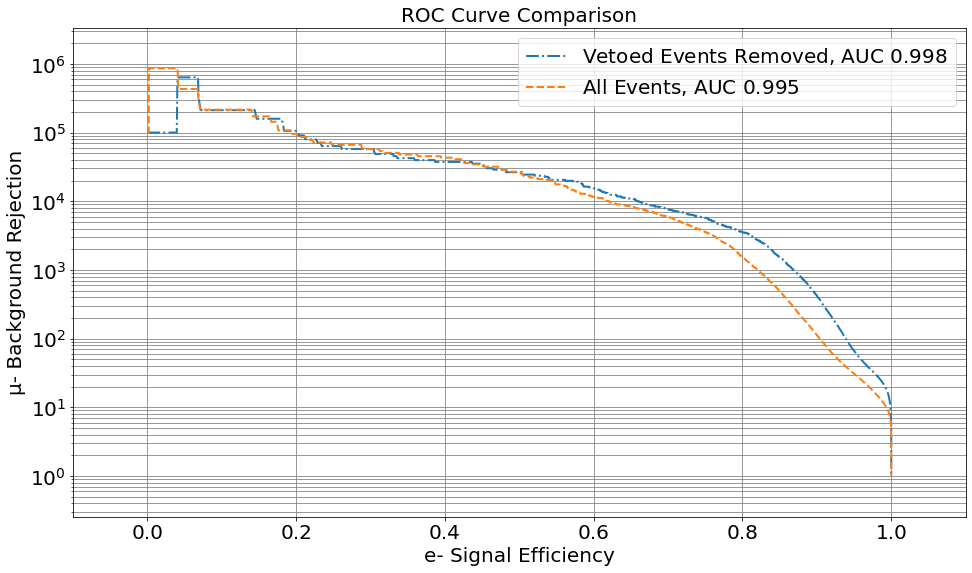

In [17]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','mu']], 
                                plot_labels = ['Vetoed Events Removed', 'All Events'],
                                png_name = None,title='ROC Curve Comparison',annotate=False,
                                linestyle=('dashdot','--'), xlabel='e- Signal Efficiency',ylabel='\u03BC- Background Rejection')
